### 01- Biuld

In [57]:
import subprocess, os, shutil, itertools, re, time, datetime
from pathlib import Path
import pandas as pd

# log

def log(msg: str) -> None:
    ts = datetime.datetime.now().strftime("%H:%M:%S")
    print(f"[{ts}] {msg}")

# paths
ROOT  = Path(".").resolve()
BUILD = ROOT / "build"

SERIAL_EXE = "./serial"
OPENMP_EXE = "./openmp"
CUDA_EXE   = "./cuda"

### 02 - helpers de build/exec

In [58]:
def run(cmd, workdir=ROOT, env=None):
    log(f"▶️  run: {cmd}")
    t0 = time.perf_counter()
    res = subprocess.run(cmd, shell=True, cwd=workdir,
                         env=env, text=True, capture_output=True)
    dt = time.perf_counter() - t0
    log(f"✅ finished: {cmd}  ( {dt:.2f}s)\n")
    return res.stdout + res.stderr, res.returncode, dt

def cmake_config(cmake_opts=""):
    if BUILD.exists():
        shutil.rmtree(BUILD)
    BUILD.mkdir()
    log(f"cmake .. {cmake_opts}")
    out, rc, _ = run(f"cmake .. -DCMAKE_BUILD_TYPE=Release {cmake_opts}", BUILD)
    if rc:
        raise RuntimeError(out)

def make():
    log("make -j$(nproc)")
    out, rc, _ = run("make -j$(nproc)", BUILD)
    if rc:
        raise RuntimeError(out)

def parse_time(log_text, key):
    pat = rf"(?im)^[ \t]*{key}:[ \t]*([0-9]+(?:\.[0-9]+)?)\s*$"
    m = re.search(pat, log_text)
    if not m:
        raise ValueError(f"não achei tempo para '{key}'.\nSaída:\n{log_text}")
    return float(m.group(1))

### wrappers runtime

In [59]:
def run_serial():
    return parse_time(run(SERIAL_EXE, BUILD)[0], "serial")


def run_openmp(nt):
    env = os.environ.copy(); env["OMP_NUM_THREADS"] = str(nt)
    return parse_time(run(OPENMP_EXE, BUILD, env)[0], "openmp")


def run_cuda(bx, by):
    env = os.environ.copy()
    env["BLOCK_X"], env["BLOCK_Y"] = str(bx), str(by)
    return parse_time(run(CUDA_EXE, BUILD, env)[0], "cuda")

### benchmark

In [60]:
def bench(size_list=(100,),
          tile_list=(32,),
          tb_list=(1,),
          nthreads=(1,2,4,8),
          blocks=((32,8),),
          nrep=3):
    """Executa benchmark e devolve DataFrame."""

    rows = []

    for N in size_list:                          # loop sobre tamanhos
        size_flags = f"-DNX={N} -DNY={N}"

        for tile, tb in itertools.product(tile_list, tb_list):
            base_flags = f"{size_flags} -DTILE={tile} -DTB={tb}"

            log(f"Build cfg: {base_flags}")
            cmake_config(base_flags)
            make()

            # serial
            t_ser = min(run_serial() for _ in range(nrep))
            tag   = f"N{N}_T{tile}_TB{tb}"
            rows.append({"variant":"serial","cfg":tag,
                         "param":"-", "time":t_ser, "speedup":1.0})
            log(f"serial {tag}: {t_ser:.4f}s")

            # OpenMP
            for nt in nthreads:
                t = min(run_openmp(nt) for _ in range(nrep))
                rows.append({"variant":"openmp","cfg":tag,
                             "param":f"{nt} thr", "time":t,
                             "speedup":t_ser/t})
                log(f"openmp {nt} thr {tag}: {t:.4f}s  (×{t_ser/t:.2f})")

            # CUDA
            for bx, by in blocks:
                flags = f"{base_flags} -DBLOCK_X={bx} -DBLOCK_Y={by}"
                log(f"🏗️  Re-build CUDA cfg: {flags}")
                cmake_config(flags)
                make()
                t = min(run_cuda(bx, by) for _ in range(nrep))
                rows.append({"variant":"cuda","cfg":tag,
                             "param":f"{bx}x{by}", "time":t,
                             "speedup":t_ser/t if t else float('inf')})
                log(f"cuda {bx}x{by} {tag}: {t:.4f}s  (×{t_ser/t:.2f})")

    df = pd.DataFrame(rows)
    log("Benchmark concluído! \n")
    return df

In [ ]:
df = bench(
    size_list=(100, 1000, 1500, 2000),
    tile_list=(16, 32),
    tb_list=(1, 2),
    nthreads=(2, 4, 8),
    blocks=((16,16), (32,8)),
    nrep=5
)
pd.set_option("display.max_rows", None)
print(df)

[12:28:55] Build cfg: -DNX=100 -DNY=100 -DTILE=16 -DTB=1
[12:28:55] cmake .. -DNX=100 -DNY=100 -DTILE=16 -DTB=1
[12:28:55] ▶️  run: cmake .. -DCMAKE_BUILD_TYPE=Release -DNX=100 -DNY=100 -DTILE=16 -DTB=1
[12:28:58] ✅ finished: cmake .. -DCMAKE_BUILD_TYPE=Release -DNX=100 -DNY=100 -DTILE=16 -DTB=1  ( 2.76s)

[12:28:58] make -j$(nproc)
[12:28:58] ▶️  run: make -j$(nproc)
[12:28:59] ✅ finished: make -j$(nproc)  ( 0.88s)

[12:28:59] ▶️  run: ./serial
[12:29:02] ✅ finished: ./serial  ( 2.87s)

[12:29:02] ▶️  run: ./serial
[12:29:05] ✅ finished: ./serial  ( 3.53s)

[12:29:05] ▶️  run: ./serial
[12:29:09] ✅ finished: ./serial  ( 3.47s)

[12:29:09] ▶️  run: ./serial
[12:29:12] ✅ finished: ./serial  ( 3.33s)

[12:29:12] ▶️  run: ./serial
[12:29:15] ✅ finished: ./serial  ( 3.26s)

[12:29:15] serial N100_T16_TB1: 2.8705s
[12:29:15] ▶️  run: ./openmp
[12:29:16] ✅ finished: ./openmp  ( 0.39s)

[12:29:16] ▶️  run: ./openmp
[12:29:16] ✅ finished: ./openmp  ( 0.36s)

[12:29:16] ▶️  run: ./openmp
[12:29

In [ ]:
df

,variant,cfg,param,time,speedup
0,serial,N100_T16_TB1,-,3.507586,1.000000
1,openmp,N100_T16_TB1,2 thr,0.716654,4.894393
2,openmp,N100_T16_TB1,4 thr,0.638989,5.489274
3,openmp,N100_T16_TB1,8 thr,0.721859,4.859101
4,cuda,N100_T16_TB1,16x16,0.007973,439.940528
...,...,...,...,...,...
91,openmp,N2000_T32_TB2,2 thr,0.569119,6.800049
92,openmp,N2000_T32_TB2,4 thr,0.642531,6.023113
93,openmp,N2000_T32_TB2,8 thr,0.608405,6.360955
94,cuda,N2000_T32_TB2,16x16,0.007916,488.917595


### Graph plot

/tmp/ipykernel_6829/2113404339.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_no_serial, x="variant", y="speedup", estimator="mean", ci="sd")


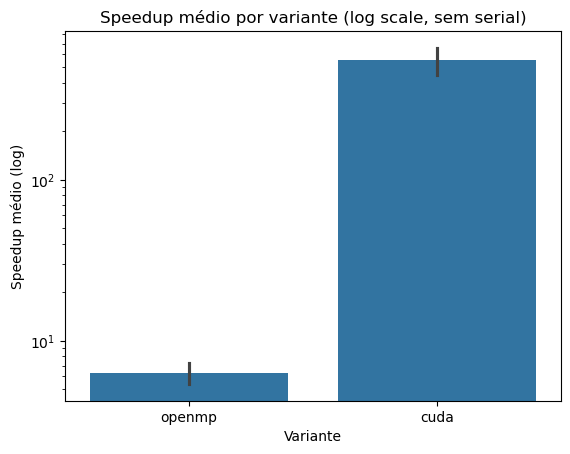

In [ ]:
#df.groupby("variant")["speedup"].mean()

import seaborn as sns
import matplotlib.pyplot as plt

# Remove serial
df_no_serial = df[df["variant"] != "serial"]

# Gráfico com eixo y em escala log
sns.barplot(data=df_no_serial, x="variant", y="speedup", estimator="mean", ci="sd")
plt.yscale("log")
plt.title("Speedup médio por variante (log s# 👇 1 thread (baseline)
export OMP_NUM_THREADS=1
./build/openmp          # guarda o valor impresso, ex.:  T1=0.580340 s

# 👇 2 threads
export OMP_NUM_THREADS=2
./build/openmp          # T2=…

# 👇 8 threads (fixos nos P-cores e “grudados”)
export OMP_NUM_THREADS=8
export OMP_PLACES=cores
export OMP_PROC_BIND=close
./build/openmp          # T8=…cale)")
plt.ylabel("Speedup médio (log)")
plt.xlabel("Variante")
plt.show()


/tmp/ipykernel_6829/2550659496.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=openmp_df, x="param", y="speedup", estimator="mean", ci="sd")


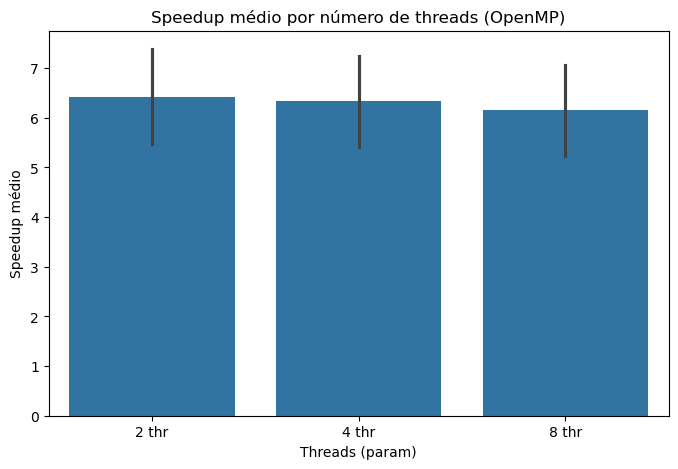

In [ ]:
openmp_df = df[df["variant"] == "openmp"]

plt.figure(figsize=(8, 5))
sns.barplot(data=openmp_df, x="param", y="speedup", estimator="mean", ci="sd")
plt.title("Speedup médio por número de threads (OpenMP)")
plt.ylabel("Speedup médio")
plt.xlabel("Threads (param)")
plt.show()


In [ ]:
df[df["variant"] == "openmp"].groupby("param")["speedup"].mean()

param
2 thr    6.425827
4 thr    6.329421
8 thr    6.150660
Name: speedup, dtype: float64

In [ ]:
df.sort_values("speedup", ascending=False).head(5)

,variant,cfg,param,time,speedup
35,cuda,N1000_T16_TB2,32x8,0.007402,724.893739
77,cuda,N2000_T16_TB1,32x8,0.007727,691.339229
82,cuda,N2000_T16_TB2,16x16,0.007065,690.858886
34,cuda,N1000_T16_TB2,16x16,0.007923,677.298286
76,cuda,N2000_T16_TB1,16x16,0.007933,673.399280


In [ ]:
df.groupby("variant")["time"].mean()

variant
cuda      0.007700
openmp    0.671528
serial    4.240735
Name: time, dtype: float64

In [ ]:
df["N"] = df["cfg"].str.extract(r"N(\d+)", expand=False).astype(int)
df.groupby(["N", "variant"])["speedup"].mean().unstack()

variant,cuda,openmp,serial
N,,,
100,517.504089,5.929628,1.0
1000,527.557285,5.980410,1.0
1500,580.505373,6.780712,1.0
2000,584.145088,6.517127,1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from pathlib import Path

def animate_wave_to_gif(data_dir="data", prefix="wave", nx=100, duration=80, gif_name="wave.gif"):
    data_dir = Path(data_dir)
    files = sorted(data_dir.glob(f"{prefix}_*.dat"))

    if not files:
        raise FileNotFoundError(f"No files matching {prefix}_*.dat in {data_dir}")

    images = []

    for f in files:
        z = np.loadtxt(f)[:, 2].reshape(nx, nx)

        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(z, cmap="viridis", origin="lower")
        ax.set_title(f.stem)
        ax.axis("off")

        temp_path = data_dir / "temp_frame.png"
        plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        images.append(imageio.imread(temp_path))

    gif_path = data_dir / gif_name
    imageio.mimsave(gif_path, images, duration=duration / 1000)

    print(f"GIF salvo em: {gif_path}")

/tmp/ipykernel_6829/3587898404.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_path))


GIF salvo em: data/wave.gif


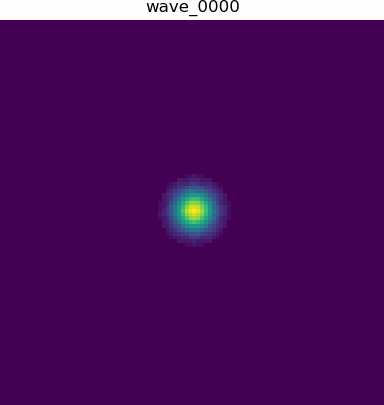

In [ ]:
animate_wave_to_gif(data_dir="data", prefix="wave", nx=100, duration=80, gif_name="wave.gif")

from IPython.display import Image
Image(filename="data/wave.gif")